# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP2-SVM-IMA205-YOUR-SURNAME.ipynb') and the answers to the theoretical questions as a single zip file to the site pédagogique before the 12th of February 2020 (23h59). Name it as 'TP2-SVM-IMA205-YOUR-SURNAME.zip'.

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [0]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

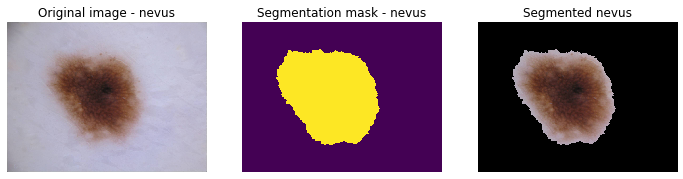

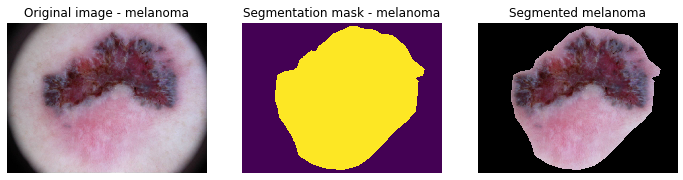

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [0]:
# Shuffle data randomly
ordre=np.arange(0,N)
np.random.shuffle(ordre)

# Use as new variables
X=X[ordre[:]]
y=y[ordre[:]]

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)

We should now test the discriminative power of our features. Let divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

Fitting LDA to training set
done in 0.023s
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       158
           1       0.62      0.33      0.43        40

    accuracy                           0.82       198
   macro avg       0.73      0.64      0.66       198
weighted avg       0.80      0.82      0.80       198

Normalized confusion matrix
[[0.94936709 0.05063291]
 [0.675      0.325     ]]


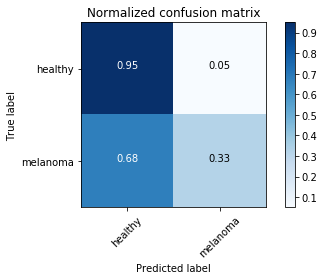

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)

# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting QDA to training set
done in 0.007s
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       158
           1       0.62      0.33      0.43        40

    accuracy                           0.82       198
   macro avg       0.73      0.64      0.66       198
weighted avg       0.80      0.82      0.80       198

Normalized confusion matrix
[[0.94936709 0.05063291]
 [0.675      0.325     ]]


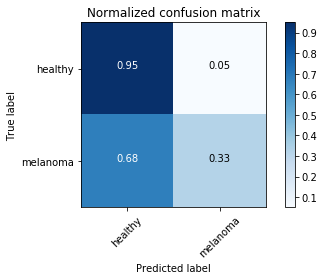

In [8]:
# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = LinearDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

--- 

**Response:**

Les résultats sont très bon sur les lésions healthy, mais beaucoup moins sur les mélanomes, dont la plupart sont prédit comme étant des healthy. 
L'algorithme apprend donc que la majorité des cellules sont des lésions saines.
En fait l'algorithme renvoie souvent la classe majoritaire : lésion saine. 
De plus, il n'y a pas de différence de résultat entre QDA et LDA, donc prendre en compte les matrices de covariance de chaque classe ne change pas grand chose dans cet exemple. 

---

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it with at least three different models (e.g. LDA, QDA, K-NN, etc)

--- 

**Response:** We can use the cross-validation and compute the CV score. 

---

In [9]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X_scale, y,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))
print(" ")

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X_scale, y ,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
print(" ")

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X_scale, y=np.ravel(y),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.046s
 Average and std CV score : 0.8116666666666668 +- 0.012472191289246466
 
Fitting QDA
done in 0.021s
 Average and std CV score : 0.7966666666666666 +- 0.011303883305208786
 
Fitting K-nearest neighbour
done in 0.073s
 Average and std CV score : 0.8049999999999999 +- 0.016329931618554505


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value. Do it and plot the confusion matrix. Do you notice anything strange ? 

The best K is 7  with an average validation score equal to  0.825925925925926
The test score is 0.8181818181818182


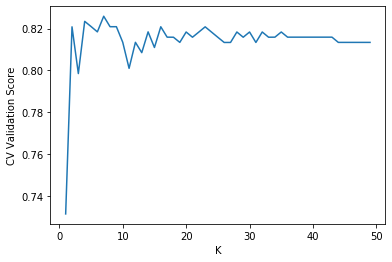

In [10]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':np.arange(1,50)}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot(np.arange(1,50), grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

Knn
done in 0.021s
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       158
           1       0.67      0.20      0.31        40

    accuracy                           0.82       198
   macro avg       0.75      0.59      0.60       198
weighted avg       0.80      0.82      0.78       198

Normalized confusion matrix
[[0.97468354 0.02531646]
 [0.8        0.2       ]]


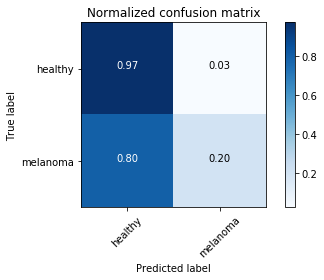

In [11]:
# Fitting Knn to original data with the best n_neighbors
print("Knn")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

--- 

Même avec le meilleur nombre de voisin possibles, le résulat pour Knn est très faible pour les mélanomes. Comme il y a une majorité de "healthy", les voisins majoritaires sont souvent "health" et cela provoque la mauvaise classification des mélanomes.

---

I strongly suggest that you look at these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
- https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

In [12]:
# Comparing different score of QDA

from sklearn.metrics import *


qda = LinearDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)


acc_score=accuracy_score(y_test, y_pred)
balanc_acc_score=balanced_accuracy_score(y_test,y_pred)
cohen_kap_score=cohen_kappa_score(y_test, y_pred)

print("The accuracy score of QDA is",acc_score)
print("The balanced accuracy score of QDA is",balanc_acc_score)
print("The Cohen-Kappa score of QDA is",cohen_kap_score)
print("The last one is considered to be good over 0.8")

The accuracy score of QDA is 0.8232323232323232
The balanced accuracy score of QDA is 0.6371835443037974
The Cohen-Kappa score of QDA is 0.3335256780150029
The last one is considered to be good over 0.8


RANDOM OVER SAMPLER

In [13]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 325), (1, 325)]


Let's retest KNN on this new data-set. Are the results better ?

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Knn to training set
done in 0.021s
              precision    recall  f1-score   support

           0       0.89      0.61      0.73       160
           1       0.30      0.68      0.41        38

    accuracy                           0.63       198
   macro avg       0.59      0.65      0.57       198
weighted avg       0.78      0.63      0.67       198

Normalized confusion matrix
[[0.6125     0.3875    ]
 [0.31578947 0.68421053]]


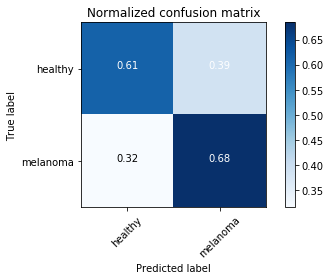

In [15]:
# Fitting Knn to original data with the best n_neighbors
print("Knn to training set")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


---

**Response:** Les résultats sont en effet meilleur après resampling des données. 
Maintenant qu'il n'y a plus de classe vraiment majoritaire, la plupart des healthy sont prédits comme des healthy et la plupart des mélanomes comme des mélanomes ! 

---

Let's use more advanced techiques such as SVM

In [16]:
# Fitting Linear SVM on original data
print("Fitting Linear SVM to the training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm, X_scale, y ,cv=5)
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

Fitting Linear SVM to the training set
done in 0.320s
Average and std CV score : 0.7166666666666667 +- 0.0372677996249965


Suppose that there are overlapping classes, we need to set the hyper-parameter C. Use Cross-Validation to find the best C value.

The best C is 8  with a score equal to  0.7662962962962963
Normalized confusion matrix
[[0.7        0.3       ]
 [0.42105263 0.57894737]]


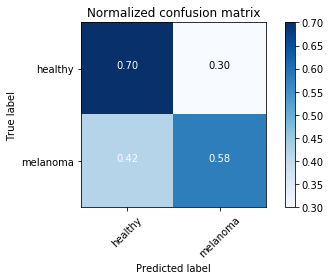

In [17]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(C=p_grid_lsvm,class_weight='balanced')
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best C is', grid.best_params_.get('C'), ' with a score equal to ', grid.best_score_)

bestLvsm = LinearSVC(C=grid.best_params_.get('C'),class_weight='balanced')
bestLvsm.fit(X_train, y_train)
y_pred = bestLvsm.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Try to use the previous SVM code but on the over-sampled data. Does the scoring result change ? 

In [18]:
print("Fitting Linear SVM to the training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm, X_resampled, y_resampled ,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

Fitting Linear SVM to the training set
done in 0.323s
 Average and std CV score : 0.7430769230769231 +- 0.02691208566851676


The best C is 1  with a score equal to  0.7430769230769231
Normalized confusion matrix
[[0.7375     0.2625    ]
 [0.42105263 0.57894737]]


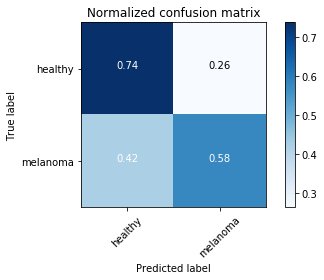

In [19]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(C=p_grid_lsvm,class_weight='balanced')
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print('The best C is', grid.best_params_.get('C'), ' with a score equal to ', grid.best_score_)

bestLvsm = LinearSVC(C=grid.best_params_.get('C'),class_weight='balanced')
bestLvsm.fit(X_resampled, y_resampled)
y_pred = bestLvsm.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

---

**Response :** Utiliser de l'over-sampling n'améliore que très peu le score du Linear SVM, qu'il y ait régularisation ou non. 

---

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

In [20]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_scale,y ,cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=5)   
grid_nlsvm.fit(X_train,y_train) 
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


Fitting Non-linear SVM to the training set
done in 29.316s
Average and std Nested Cv score : 0.8099999999999999 +- 0.04484541349024571
Best Score: 0.8084876543209877
Best params: {'C': 0.001, 'gamma': 0.0001}


Avec un SVM non-linéaire, on obtient un meilleur score d'environ 0.07 ce qui est non négligeable : comme nos données de bases ne sont pas séparables, il est intéressant de permettre la non-linéarité, tout en gardant une certaine régularisation.

Another important point is the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. balanced accuracy). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [0]:
# Implement forward feature selection and/or backward feature selection
# with a linear and/or non-linear SVM

#We define the function forward_feature_selection which selects the most important features by testing each time the new score obtained by adding a new feature.

def forward_feature_selection(x_train, x_test, y_train, y_test):
    n=len(x_train[0])
    feature_set = []
    x_train=np.array(x_train)
    for num_features in range(n):
        metric_list = [] 
        model = LinearSVC(class_weight='balanced')
        for i in range(len(x_train[0])):
          feature=i
          if feature not in feature_set:
              f_set = feature_set.copy()
              f_set.append(feature)
              model.fit(x_train[:,f_set], y_train)
              metric_list.append((model.score(x_test[:,f_set], y_test),feature))

        metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"
        feature_set.append(metric_list[0][1])
    return feature_set

Voici l'ordre d'importance des features obtenus.

In [22]:
order_of_importance=forward_feature_selection(X_train,X_test,y_train,y_test)
print(order_of_importance)

[22, 28, 9, 6, 21, 25, 4, 19, 26, 8, 7, 10, 11, 3, 1, 12, 29, 0, 2, 24, 27, 13, 14, 15, 18, 16, 23, 17, 20, 5]


Maintenant, nous allons ajouter les features un par un, regarder le score à chaque fois, et retenir ce score. 

Nous allons garder les features correspondant au meilleur score.

In [23]:
n=len(order_of_importance)
model = LinearSVC(class_weight='balanced')

best_score=0
selected_features=[]


for i in range(n):
  new_X_train=X_train[:,order_of_importance[0:(i+1)]]
  new_X_test=X_test[:,order_of_importance[0:(i+1)]]
  model.fit(new_X_train, y_train)
  score=model.score(new_X_test, y_test)
  if score>best_score:
    best_score=score
    selected_features=order_of_importance[0:i]

print("Nous gardons les features :",selected_features)
print("Cela donne un score avec le Linear SVC de",best_score)

Nous gardons les features : [22, 28, 9, 6, 21, 25, 4, 19, 26]
Cela donne un score avec le Linear SVC de 0.803030303030303


Normalized confusion matrix
[[0.7125     0.2875    ]
 [0.34210526 0.65789474]]


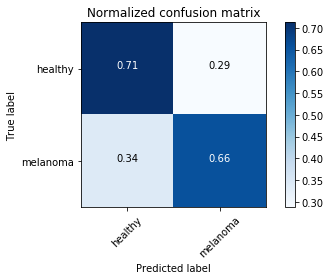

In [24]:
y_pred = model.predict(new_X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()